In [1]:
import os
import warnings
warnings.simplefilter(action='ignore') # , category=FutureWarning)

import logging

import gridop as gop
import diags as dg
import plot as cplt
from model import Model
from tools import wait_cluster_ready

### Launch dask cluster

In [2]:
from dask.distributed import Client, LocalCluster

workers_per_job = 28
jobs = 1
nworkers = workers_per_job * jobs

# pour 1 seul noeud
# cluster = LocalCluster(nworkers=workers_per_job, threads_per_worker=1)

# pour plusieurs noeuds:
# ** processes and cores may be adjusted in order to have more memory 
# or inversely more computational ressource
from dask_jobqueue import PBSCluster
cluster = PBSCluster(processes=workers_per_job, 
                     cores=workers_per_job, 
                     walltime='02:00:00')
w = cluster.scale(jobs=jobs)
#cluster.adapt(minimum=1, maximum=5)

client = Client(cluster)
wait_cluster_ready(cluster, nworkers)
client

100 % of the workers started: 28 workers


<Client: 'tcp://10.148.0.91:46299' processes=28 threads=28, memory=111.72 GiB>


---
### Parameters

In [3]:
# moz 2000 surf
case='surf_2000'
path = '/home/datawork-lops-osi/cmenesg/moz/'
run = path+'moz_2000x2000x360_hmin30_r0p1_ts10_tb0_hc10_UP5_GLS_GEBCO2014/'
filenames = [run + 'zarr/surf.zarr']
gridname  = run + 't1/grid.nc'
suffix=''

--- 
### Create an instance of the Model class 
which contains all the substitutions of the variables names depending on the model: 
- croco_xios

In [4]:
croco = Model("croco_xios")

### Open all the data files and the grid file and return a dataset. Create the xgcm grid.

In [5]:
%%time
drop_variables = ['time', 'nav_lon_w', 'nav_lat_w',
                  'sustr', 'svstr','bvf',
                  'hc','h','Vtransform','sc_r','sc_w',
                  'Cs_r','Cs_w','angle','mask_rho',
                  'pm','pn','Tcline','theta_s','theta_b',
                  'lon_rho','lat_rho','lon_u','lat_u','lon_v','lat_v',
                  'nav_lon_rho','nav_lat_rho','nav_lon_u','nav_lat_u','nav_lon_v','nav_lat_v',
                  't','t_bounds',
                  'time_counter_bounds',
                 ]
ds, grid = gop.open_files(croco, gridname, filenames, grid_metrics=1, 
                          drop_variables=drop_variables, suffix=suffix,
                          chunks={'t':1, 'y':-1, 'x':-1})

CPU times: user 2.39 s, sys: 232 ms, total: 2.62 s
Wall time: 2.69 s


In [6]:
ds

<xarray.Dataset>
Dimensions:       (s: 1, t: 5280, y: 2002, x: 2002, x_u: 2001, y_v: 2001,
                   s_w: 361)
Coordinates:
  * s             (s) float32 -0.001389
  * t             (t) datetime64[ns] 1994-07-11T00:29:20 ... 1994-10-28T23:59:20
    lat           (y, x) float32 dask.array<chunksize=(2002, 2002), meta=np.ndarray>
    lon           (y, x) float32 dask.array<chunksize=(2002, 2002), meta=np.ndarray>
  * s_w           (s_w) float32 -1.0 -0.9972 -0.9944 ... -0.005556 -0.002778 0.0
    lon_u         (y, x_u) float32 dask.array<chunksize=(2002, 2001), meta=np.ndarray>
    lat_u         (y, x_u) float32 dask.array<chunksize=(2002, 2001), meta=np.ndarray>
    lon_v         (y_v, x) float32 dask.array<chunksize=(2001, 2002), meta=np.ndarray>
    lat_v         (y_v, x) float32 dask.array<chunksize=(2001, 2002), meta=np.ndarray>
    lon_f         (y_v, x_u) float32 dask.array<chunksize=(2001, 2001), meta=np.ndarray>
    lat_f         (y_v, x_u) float32 dask.array<chunksize=(2001, 2001), meta=np.ndarray>
Dimensions without coordinates: y, x, x_u, y_v
Data variables: (12/29)
    z_sfc         (t, y, x) float32 dask.array<chunksize=(1, 2002, 2002), meta=np.ndarray>
    sss           (t, s, y, x) float32 dask.array<chunksize=(1, 1, 2002, 2002), meta=np.ndarray>
    sst           (t, s, y, x) float32 dask.array<chunksize=(1, 1, 2002, 2002), meta=np.ndarray>
    ssu           (t, s, y, x_u) float32 dask.array<chunksize=(1, 1, 2002, 2001), meta=np.ndarray>
    ssv           (t, s, y_v, x) float32 dask.array<chunksize=(1, 1, 174, 2002), meta=np.ndarray>
    time_instant  (t) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    ...            ...
    dx_psi        (y_v, x_u) float32 dask.array<chunksize=(2001, 2001), meta=np.ndarray>
    dy_psi        (y_v, x_u) float32 dask.array<chunksize=(2001, 2001), meta=np.ndarray>
    rAr           (y_v, x_u) float32 dask.array<chunksize=(2001, 2001), meta=np.ndarray>
    rAu           (y_v, x) float32 dask.array<chunksize=(2001, 2002), meta=np.ndarray>
    rAv           (y, x_u) float32 dask.array<chunksize=(2002, 2001), meta=np.ndarray>
    rAf           (y, x) float32 dask.array<chunksize=(2002, 2002), meta=np.ndarray>

### plot a single image

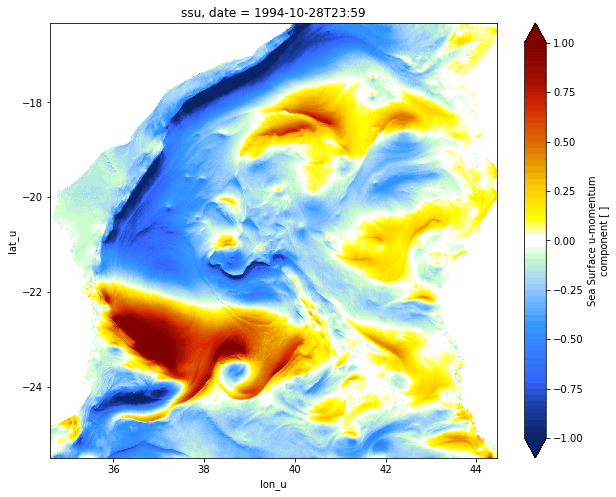

In [7]:
da=ds.ssu.isel(t=-1)
kwargs = {'vmin': -1, 'vmax': 1, 'extend':'both'}
cplt.plotfig(da, **kwargs)

In [8]:
%%time
da=ds.ssu.isel(t=slice(0,None,6))
kwargs = {'vmin':-1, 'vmax':1, 'extend':'both'}
cplt.movie_wrapper(da, client, **kwargs)

ffmpeg -framerate 5  -i /home1/scratch/slgentil/figs/ssu_t%05d.png -vcodec mpeg4 -y /home1/scratch/slgentil/figs/ssu.mp4


ffmpeg version 5.0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 10.3.0 (GCC)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1649114005999/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1649114005999/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-demuxer=dash --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-vaapi --enable-libx264 --enable-libx265 --enable-libaom --enable-libsvtav1 --enable-libxml2 --enable-libvpx --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame --pkg-config=/home/conda/feedstock_root/build_artifacts/ffmpeg_1649114005999/_build_env/bin/pkg-config
  libavutil      57. 17.

CPU times: user 2min 8s, sys: 1min 30s, total: 3min 38s
Wall time: 7min 7s


In [9]:
from ipywidgets import Video
fig_dir = os.environ['SCRATCH']+'/figs/'
fig_suffix = ''.join(da.name)
movie_name = fig_dir+fig_suffix+'.mp4'
video = Video.from_file(movie_name)
video

Video(value=b'\x00\x00\x00\x1cftypisom\x00\x00\x02\x00isomiso2mp41\x00\x00\x00\x08free\x00\x91\xa0\xf9mdat\x00…

In [10]:
# cluster.close()

distributed.scheduler - ERROR - broadcast to tcp://10.148.0.54:46676 failed: OSError: Timed out trying to connect to tcp://10.148.0.54:46676 after 10 s
distributed.scheduler - ERROR - broadcast to tcp://10.148.0.54:51418 failed: OSError: Timed out trying to connect to tcp://10.148.0.54:51418 after 10 s
distributed.scheduler - ERROR - broadcast to tcp://10.148.0.54:50777 failed: OSError: Timed out trying to connect to tcp://10.148.0.54:50777 after 10 s
distributed.scheduler - ERROR - broadcast to tcp://10.148.0.54:33440 failed: OSError: Timed out trying to connect to tcp://10.148.0.54:33440 after 10 s
distributed.scheduler - ERROR - broadcast to tcp://10.148.0.54:42475 failed: OSError: Timed out trying to connect to tcp://10.148.0.54:42475 after 10 s
distributed.scheduler - ERROR - broadcast to tcp://10.148.0.54:38785 failed: OSError: Timed out trying to connect to tcp://10.148.0.54:38785 after 10 s
distributed.scheduler - ERROR - broadcast to tcp://10.148.0.54:59382 failed: OSError: Ti

KeyboardInterrupt: 